# Análise da métrica "valor total captado" de um projeto cultural
---

**Objetivo:** realizar uma análise comparativa entre o valor total captado de todos os projetos culturais de um mesmo segmento. Nesta análise, será investigado se o valor total captado de um projeto cultural específico é anormal com relação aos demais projetos do mesmo segmento. 

Para detectar anomalias/outliers serão utilizadas diversas estratégias, tanto de modelos de distribuição para aproximar a PDF (Probability Density Function) da RV (Random Variable) gerada pela métrica, quanto as baseadas em amostras, como é o caso do detector de outlier LOF (Local Outlier Factor).

Issue relacionada ao estudo:
* [#169](https://github.com/lappis-unb/salic-ml/issues/175): Valor Captado - Evoluir notebook comparando Gaussiana com LOF

Documentação relacionada:
* \[[link](https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira)\] Brainstorming de features para estimar a Complexidade Financeira

## Metodologia

Foram aplicados cinco modelos de detecção de anomalias: quatro baseados na aproximação da Função de Densidade de Probabilidade (PDF) e um baseado na exploração da densidade de amostras ao redor de um ponto específico (LOF). 

Para todos os modelos, a estratégia seguida foi a mesma. Primeiramente, dividiu-se o conjunto amostral em conjunto de treinamento (70% dos dados) e conjunto de teste (os 30% restantes dos dados).
Em seguida, cada um dos modelos foi treinado com o conjunto de treinamento, supondo uma taxa de contaminação fixa de 10% das amostras (contaminação é a taxa de outliers contidos na amostra).
O conjunto de testes foi passado a cada modelo, que retornou a relação de amostras rotuladas como inliers/outliers. Os tempos de treinamento e teste foram anotados e criou-se uma figura contendo dois histogramas, um para os inliers e um para os outliers.
Além disso, a métrica de contaminação encontrada foi levantada para comparar a eficiência de cada um dos cinco modelos.

#### Detecção de anomalias baseada na aproximação da PDF por modelos de distribuição

A PDF dos dados observados foi ajustada às seguintes distribuições:

* Distribuição Gaussiana;
* Distribuição Log-Normal;
* Distribuição Gamma;
* Estimação de Distribuição por Kernel Gaussiano (KDE).

O treinamento de todos os quatro modelos de distribuição consiste em ajustar a curva ao conjunto de treinamento e então encontrar, via bisseção, um limiar de densidade de probabilidade $p$, tal que, dada uma taxa de contaminação $c$, a igualdade abaixo é satisfeita:

$$ c = \int_{\forall x \ \vert \ f_X(x) < p}f_X(x)dx $$

Onde $f_X$ é a PDF encontrada ao ajustar cada uma das distribuições utilizadas.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta verificar se $f_X(x) \geq p$ ou $f_X(x) < p$, respectivamente, ou seja, $x$ é outlier se ele é pouco provável de acontecer, segundo a distribuição utilizada.

#### Detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico

O último modelo utilizado foi o _Local Outlier Factor_ (LOF), que verifica se uma amostra é um outlier ao comparar a densidade de amostras ao seu redor com a densidade de amostras de suas vizinhas. Caso uma amostra tenha densidade muito menor que suas vizinhas, ela é considerada um outlier.

O treinamento do LOF utiliza o `OutlierDetection` da classe `sklearn.neighbors.LocalOutlierFactor` para verificar quais são os outliers do conjunto de treinamento, passando a contaminação como parâmetro. Em seguida, os outliers são retirados do conjunto de treinamento e o LOF em si é treinado utilizando o `NoveltyDetection` da mesma classe.

Para verificar se uma nova amostra $x$ é um inlier ou um outlier, basta utilizar a função `predict` da `NoveltyDetection` para verificar se tal amostra tem uma densidade de amostras muito menor que a de sua vizinhança.

#### Validação da contaminação encontrada

Por fim, para avaliar de forma mais consistente a contaminação encontrada por cada um dos modelos utilizados, o procedimento de treino e teste foi repetido 100 vezes, sempre fixando a contaminação esperada em 10% e salvando a contaminação encontrada no conjunto de teste.

## Resultados

Serão analisados os resultados com base nos seguinte critérios: tempo de execução de treino/teste, efetividade do modelo com relação à taxa de contaminação encontrada, e efetividade do modelo com relação a quais amostras foram rotuladas como outliers.

#### Tempo de execução de treino e teste

Os tempos de execução estão mostrados a seguir, ordenados pelo de menor tempo de teste para o maior:

* Metric Gaussian test elapsed time in seconds: 0.0143

* Metric Gaussian training elapsed time in seconds: 0.2947

* Metric Gamma test elapsed time in seconds: 0.0167

* Metric Gamma training elapsed time in seconds: 0.3571

* Metric Log-normal test elapsed time in seconds: 0.0228

* Metric Log-normal training elapsed time in seconds: 0.4578

* Metric LOF test elapsed time in seconds: 0.0932

* Metric LOF training elapsed time in seconds: 0.6392

* Metric KDE-Gauss test elapsed time in seconds: 0.4615

* Metric KDE-Gauss training elapsed time in seconds: 1.6418

#### Taxa de contaminação encontrada
As taxas de contaminação encontradas para cada um dos modelos foram:

* Média KDE-Gauss: 7.85%
* Média Gaussian: 13.15%
* Média Log-normal: 13.91%
* Média Gamma: 16.37%
* Média LOF: 18.27%

A que mais se aproxima da contaminação esperada (10%) é o modelo KDE-Gauss, seguido por: Gaussian, Log-normal, Log-normal e Gamma.

#### Quais amostras foram rotuladas como outliers

Nos modelos de detecção de anomalias baseada na aproximação da PDF por modelos de distribuição, fica claro que os projetos rotulados como outliers têm valor muito abaixo ou muito acima da média, já o modelo de detecção de anomalias baseada na exploração da densidade de amostras ao redor de um ponto específico, LOF, amostras com valores consideravelmente próximos à média da distribuição foram rotuladas como outliers, o que não parece fazer sentido para o contexto.

## Conclusões

O modelo KDE-Gauss apresenta a contaminação mais próxima da contaminação esperada, sendo assim, levando em conta o hipótese de maior proximidade de contaminação, é a métrica mais apropriada nesse quesito. Entretanto, o mesmo apresenta tempos de treinamento e teste (i.e., tempos de query) muito elevados quando comparado com os outros modelos.
Como alternativa, o modelo Gaussian é o segundo mais próximo da contaminação esperada e seu tempo de teste (queries) é o melhor, se provando, talvez, como a melhor opção caso o tempo elevado do modelo KDE-Gauss seja um problema para as situações a serem usadas.

#### Trabalhos futuros

Escolheu-se um segmento específo e todo o estudo foi realizado com base nos dados daquele segmento. Um trabalho futuro é a realização das mesmas análises e generalização para os outros segmentos.

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### Carregando e mostrando dataset a ser utilizado ao longo do estudo

In [2]:
df = pd.read_csv('../../data/raw/planilha_comprovacao.csv')
print(df.columns)
df.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')


/home/mattioli/Desktop/unb/lappis/virtual_env/salic-ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,PRONAC,idPlanilhaAprovacao,idComprovantePagamento,IdPRONAC,idSegmento,cdProduto,cdEtapa,cdUF,UF,cdCidade,...,dtPagamento,dtEmissao,tpFormaDePagamento,nrDocumentoDePagamento,idArquivo,dsJustificativaProponente,dsOcorrenciaDoTecnico,stItemAvaliado,stAvaliacao,vlComprovacao
0,1012121,18552,4326,132451,71,1,1,35,SP,355030,...,2014-01-16 00:00:00,2013-03-27 00:00:00,Transferencia Bancaria,42501,410880,Elaboração de projeto gráfico do livro.,NaN,4,Aguardando analise,12000.0
1,1012121,18553,4332,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-04-30 00:00:00,Transferencia Bancaria,2945,410935,Reportagem e produção de textos para livro.,NaN,4,Aguardando analise,6000.0
2,1012121,18554,4755,132451,71,1,2,35,SP,355030,...,2014-01-28 00:00:00,2012-03-16 00:00:00,Transferencia Bancaria,31601,420731,Fotografia artística para o livro.,NaN,4,Aguardando analise,12000.0
3,1012121,18555,4334,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2013-08-27 00:00:00,Transferencia Bancaria,90201,410939,Tratamento de imagens para o livro.,NaN,4,Aguardando analise,6000.0
4,1012121,18556,4327,132451,71,1,2,35,SP,355030,...,2014-01-16 00:00:00,2012-05-04 00:00:00,Transferencia Bancaria,2945,410917,Edição dos textos do livro.,NaN,4,Aguardando analise,8000.0


#### Gerando tabela com o valor total de gastos captados por projeto e por segmento

In [3]:
class NewProviders():
    usecols = ['PRONAC', 'IdPRONAC', 'nrCNPJCPF', 'DataProjeto', 'idPlanilhaAprovacao',
               'Item', 'nmFornecedor', 'idSegmento', 'UF', 'cdProduto', 'cdCidade',
               'idPlanilhaItem', 'cdEtapa']

    def __init__(self, dt_comprovacao):
        self.dt_comprovacao = dt_comprovacao[NewProviders.usecols].copy()
        self._train()

    def _train(self):
        self._set_projects_groupby()
        self._set_providers_count()
        self._train_average_percentage()

    def _set_projects_groupby(self):
        self.projects = self.dt_comprovacao.groupby('PRONAC')

    def _set_providers_count(self):
        self.providers_count = {}

        for pronac, items in self.projects:
            cnpjs = items['nrCNPJCPF'].unique()

            for cnpj in cnpjs:
                count = self.providers_count.setdefault(cnpj, 0)
                self.providers_count[cnpj] = count + 1

    def _train_average_percentage(self):
        segment_percentages = {}
        all_projects_percentages = []

        for pronac, items in self.projects:
            cnpjs = items.nrCNPJCPF.unique()
            new_providers = 0
            for cnpj in cnpjs:
                cnpj_count = self.providers_count.get(cnpj, 0)
                if cnpj_count <= 1:
                    new_providers += 1

            id_segmento = items.iloc[0]['idSegmento']
            segment_percentages.setdefault(id_segmento, [])
            providers_percent = new_providers / cnpjs.size
            segment_percentages[id_segmento].append(providers_percent)
            all_projects_percentages.append(providers_percent)

        self.segments_average = {}
        for segment_id, percentages in segment_percentages.items():
            mean = np.mean(percentages)
            self.segments_average[segment_id] = mean

        self.all_projects_average = np.mean(all_projects_percentages)
    
    def get_percentage(self, pronac):
        items = self.projects.get_group(pronac)
        
        new_providers = 0
        for cnpj in items['nrCNPJCPF'].unique():
            cnpj_count = self.providers_count.get(cnpj, 0)
            if cnpj_count <= 1:
                new_providers += 1
        
        new_providers_percentage = new_providers / len(items['nrCNPJCPF'].unique())
        
        return new_providers_percentage

new_providers_obj = NewProviders(df)

In [4]:
new_providers = df[['idSegmento', 'PRONAC']].drop_duplicates()
new_providers = new_providers.groupby(['idSegmento', 'PRONAC']).count()
index = new_providers.index
new_providers.reset_index(level=new_providers.index.names, inplace=True)
new_providers['newProvidersPercentage'] = new_providers.PRONAC.apply(new_providers_obj.get_percentage)
new_providers.index = index

## Análise por segmento
---

Nesta etapa, analisaremos o valor total de gastos captados dos projetos para um segmento escolhido.

#### Esolhendo um segmento e gerando uma lista de valor total captado para todos os projetos do segmento

In [5]:
segment = '11'
segment_projects = new_providers.loc[segment]['newProvidersPercentage']
segment_projects
#new_providers.drop(columns=['idSegmento', 'PRONAC'], inplace=True)
#new_providers.head()

PRONAC
112465     0.640000
113951     0.590909
118216     0.444444
118687     0.133333
119550     0.000000
120629     0.285714
120729     0.500000
120953     0.444444
120977     0.619565
121257     0.666667
121761     0.166667
123330     0.857143
123402     0.562500
124545     0.304348
124984     0.454545
125360     0.533333
126557     0.000000
126727     0.400000
126776     0.789474
126837     0.823529
126963     0.250000
127066     0.632653
127206     0.000000
127798     0.000000
128120     0.483871
128237     0.500000
128615     0.500000
128646     0.545455
129151     0.000000
129229     0.888889
             ...   
1414102    0.347826
1414111    0.818182
1414129    0.312500
1414132    0.205882
1414152    0.250000
1414166    0.404494
1414267    0.836364
1414382    0.100000
1510203    0.185185
1510263    0.125000
1510332    0.444444
1510413    0.333333
1510420    0.471429
1510490    0.571429
1510520    0.526316
1510609    0.533937
1510866    0.115385
1510933    0.500000
1510943    0.

#### Gerando histograma dos dados acima

Média da distribuição: 0.44
Desvio padrão da distribuição: 0.25



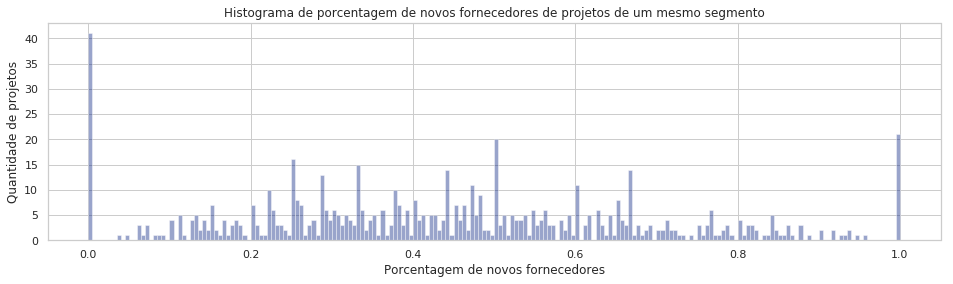

In [6]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(segment_projects, bins=200, kde=False)
plt.title('Histograma de porcentagem de novos fornecedores de projetos de um mesmo segmento')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Porcentagem de novos fornecedores')
plt.grid(True)

expected_mean = np.mean(segment_projects)
expected_std = np.std(segment_projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [7]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
1511109    0.481818
129860     0.500000
145626     0.421875
131483     0.481481
1310148    0.000000
Name: newProvidersPercentage, dtype: float64

PRONAC
154078    0.333333
163894    0.285714
152405    0.356436
152714    0.062500
154851    0.462963
Name: newProvidersPercentage, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [8]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bin_factor = 0
    if len(inliers) > 0:
        bin_factor = (max(inliers) - min(inliers))
    bins = max(1, int(bin_factor // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        plt.plot(x,  bin_size * len(test_set) * model.model.pdf(x), label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('raised funds (R$)')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [9]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

## Modelo Gaussiano

Tempo de treinamento: 0.014 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 11.62%


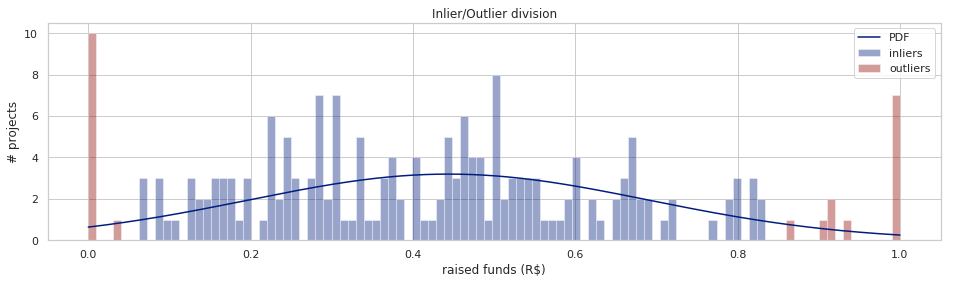

In [10]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.01)

## Modelo Log-normal

Tempo de treinamento: 0.005 (s)
Tempo de teste: 0.000 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 14.65%


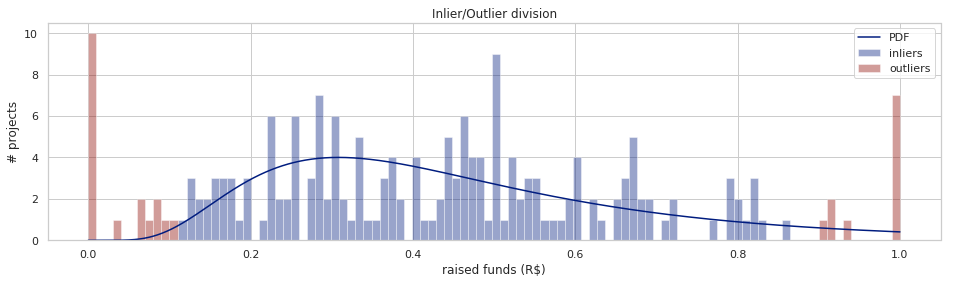

In [11]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = X[X > 0.00]
        X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(), projects_train, projects_test, bin_size=0.01)

## Modelo Gamma

Tempo de treinamento: 0.005 (s)
Tempo de teste: 0.000 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 15.66%


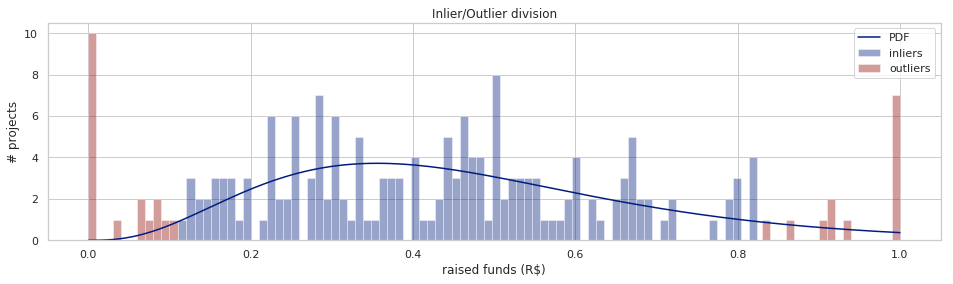

In [12]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        X = X[X > 0.0]
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.01)

## Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.018 (s)
Tempo de teste: 0.005 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 6.06%


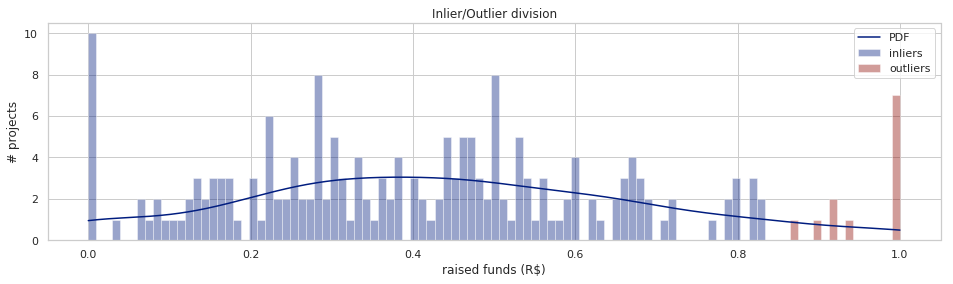

In [13]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=0.01)

## Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 0.010 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 12.63%


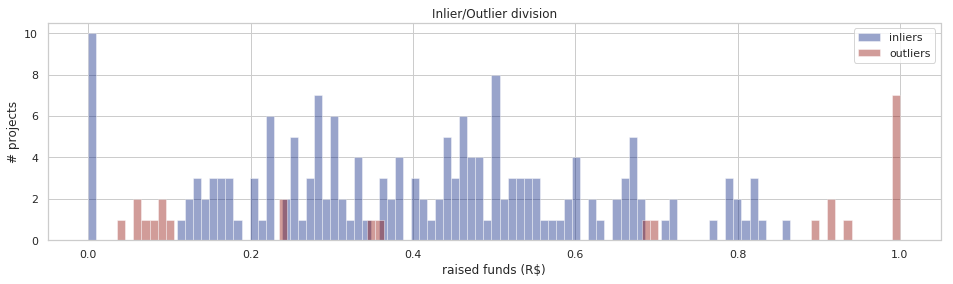

In [14]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=None):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        
        if self.n_neighbors is None:
            self.n_neighbors = len(X) // 5
        
        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=self.contamination)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=0.01)

## Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [17]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

TEST_ITERATIONS = 100
train_elapsed_time = {}
test_elapsed_time = {}

for i in range(TEST_ITERATIONS):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(segment_projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        start_time = time.time()
        model['curve'] = model['curve'].fit(projects_train)
        ending_time = time.time()
        elapsed_time = ending_time - start_time
        
        model_name = model['name']
        train_elapsed_time.setdefault(model_name, 0.0)
        train_elapsed_time[model_name] += elapsed_time

        start_time = time.time()
        inlier_filter = model['curve'].predict(projects_test)
        ending_time = time.time()
        elapsed_time = ending_time - start_time

        model_name = model['name']
        test_elapsed_time.setdefault(model_name, 0.0)
        test_elapsed_time[model_name] += elapsed_time

        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)
        
for key in train_elapsed_time:
    print("Metric %s test elapsed time in seconds: %.4lf" % (key, test_elapsed_time[key]))
    print("Metric %s training elapsed time in seconds: %.4lf" % (key, train_elapsed_time[key]))

Metric Gaussian test elapsed time in seconds: 0.0143
Metric Gaussian training elapsed time in seconds: 0.2947
Metric Log-normal test elapsed time in seconds: 0.0228
Metric Log-normal training elapsed time in seconds: 0.4578
Metric Gamma test elapsed time in seconds: 0.0167
Metric Gamma training elapsed time in seconds: 0.3571
Metric KDE-Gauss test elapsed time in seconds: 0.4615
Metric KDE-Gauss training elapsed time in seconds: 1.6418
Metric LOF test elapsed time in seconds: 0.0932
Metric LOF training elapsed time in seconds: 0.6392


Média Gaussian: 13.15%
Média Log-normal: 13.91%
Média Gamma: 16.37%
Média KDE-Gauss: 7.85%
Média LOF: 18.27%


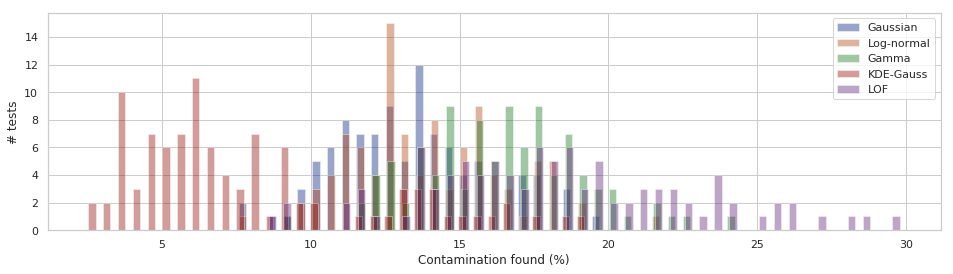

In [18]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.25
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)